# Standard Q-learning - allocentric environment

## Initialization

In [1]:
# Import packages
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
# Load custom functions
from utils import Params
from environment import WrappedEnvironment, Actions, CONTEXTS_LABELS, Cues
from agent import Qlearning, EpsilonGreedy
import plotting

In [3]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Choose the task parameters

In [4]:
# Choose the parameters for the task
params = Params(epsilon=0.1, n_runs=100, numEpisodes=300)
params

Params(epsilon=0.1, gamma=0.8, alpha=0.05, jointRep=True, n_runs=100, numEpisodes=300)

## Load the environment and the agent algorithms

In [5]:
# Load the environment
env = WrappedEnvironment(params)

In [6]:
# Load the agent algorithms
learner = Qlearning(
    learning_rate=params.alpha,
    gamma=params.gamma,
    state_size=env.numStates,
    action_size=env.numActions,
)
explorer = EpsilonGreedy(epsilon=params.epsilon)

## States and actions meaning

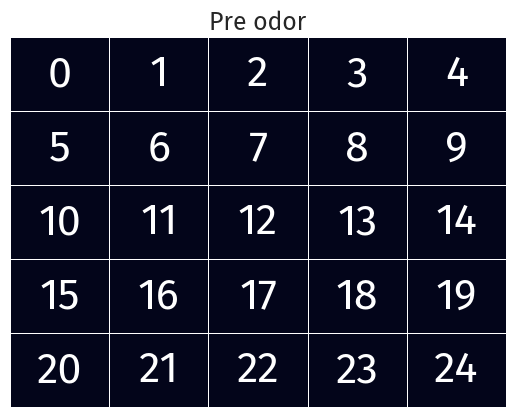

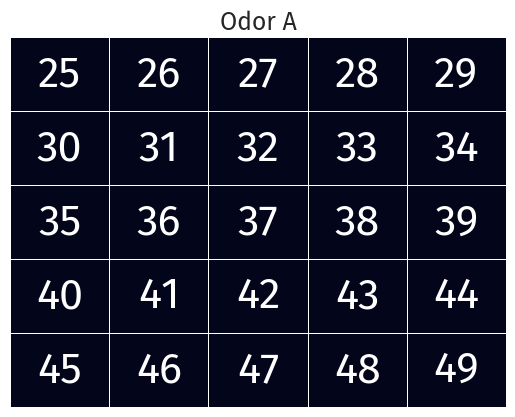

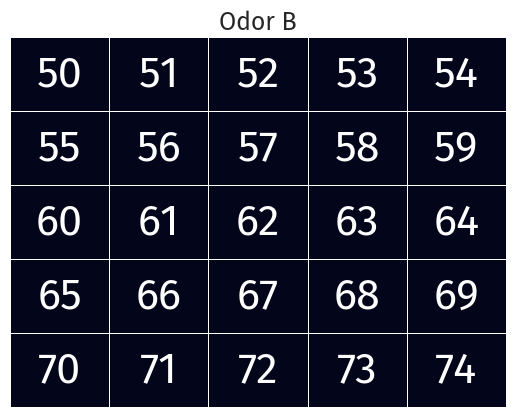

In [7]:
# State space
for idx, cue in enumerate(CONTEXTS_LABELS):
    plotting.plot_tiles_locations(
        np.array(list(env.tiles_locations)) + idx * len(env.tiles_locations),
        env.rows,
        env.cols,
        title=CONTEXTS_LABELS[cue],
    )

### Correspondance between flat states and (internal) composite states

In [8]:
state = 63
env.convert_flat_state_to_composite(state)

{'location': 13, 'cue': <Cues.OdorB: 2>}

In [9]:
env.convert_composite_to_flat_state({"location": 13, "cue": Cues.OdorA})

38

### Action meaning

In [10]:
action = 0
Actions(action)

<Actions.UP: 0>

## Main loop

In [11]:
rewards = np.zeros((params.numEpisodes, params.n_runs))
steps = np.zeros((params.numEpisodes, params.n_runs))
episodes = np.arange(params.numEpisodes)
qtables = np.zeros((params.n_runs, env.numStates, env.numActions))
all_states = []
all_actions = []

for run in range(params.n_runs):  # Run several times to account for stochasticity
    learner.reset_qtable()  # Reset the Q-table between runs

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{params.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        step_count = 0
        done = False
        total_rewards = 0

        while not done:
            action = explorer.choose_action(
                action_space=env.action_space(), state=state, qtable=learner.qtable
            )

            # Record states and actions
            all_states.append(state)
            all_actions.append(Actions(action).name)

            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, done = env.step(action, state)

            learner.qtable[state, action] = learner.update(
                state, action, reward, new_state
            )

            total_rewards += reward
            step_count += 1

            # Our new state is state
            state = new_state

        # explorer.epsilon = explorer.update_epsilon(episode)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
    qtables[run, :, :] = learner.qtable

## Postprocessing

In [12]:
res = pd.DataFrame(
    data={
        "Episodes": np.tile(episodes, reps=params.n_runs),
        "Rewards": rewards.flatten(order="F"),
        "Steps": steps.flatten(order="F"),
    }
)
res["cum_rewards"] = rewards.cumsum(axis=0).flatten(order="F")
# st = pd.DataFrame(data={"Episodes": episodes, "Steps": steps.mean(axis=1)})
qtable = qtables.mean(axis=0)  # Average the Q-table between runs

In [13]:
res

,Episodes,Rewards,Steps,cum_rewards
0,0,0.0,114.0,0.0
1,1,0.0,80.0,0.0
2,2,10.0,19.0,10.0
3,3,10.0,12.0,20.0
4,4,0.0,71.0,20.0
...,...,...,...,...
29995,295,10.0,6.0,2900.0
29996,296,10.0,6.0,2910.0
29997,297,10.0,9.0,2920.0
29998,298,10.0,44.0,2930.0


In [14]:
tmp = []
for idx, st in enumerate(tqdm(all_states)):
    tmp.append(env.convert_flat_state_to_composite(st))
all_state_composite = pd.DataFrame(tmp)
all_state_composite

100%|█████████████████████████████████████████████████████| 977649/977649 [00:01<00:00, 613544.58it/s]


,location,cue
0,6,Cues.NoOdor
1,6,Cues.NoOdor
2,11,Cues.NoOdor
3,6,Cues.NoOdor
4,6,Cues.NoOdor
...,...,...
977644,15,Cues.NoOdor
977645,20,Cues.OdorB
977646,21,Cues.OdorB
977647,22,Cues.OdorB


## Visualization

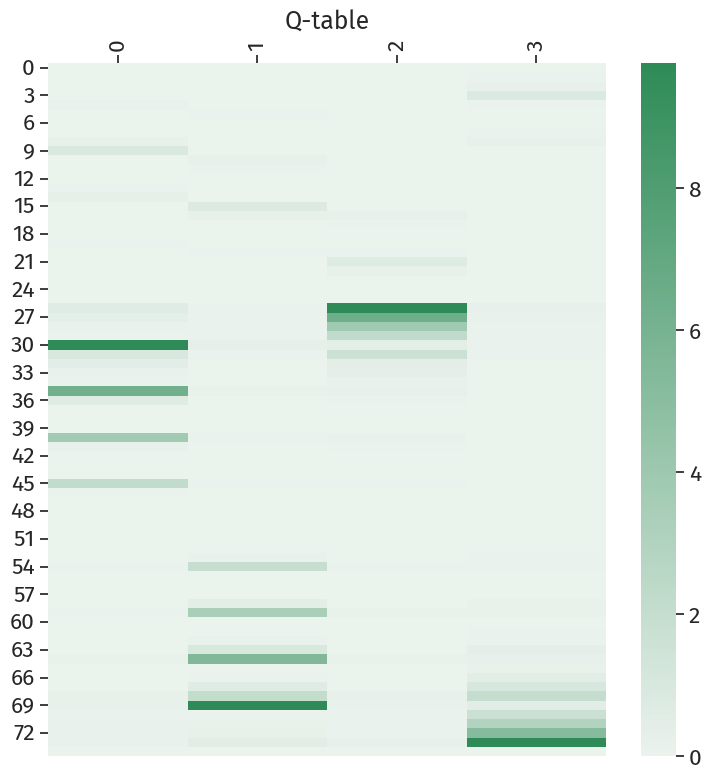

In [15]:
plotting.plot_heatmap(matrix=qtable, title="Q-table")

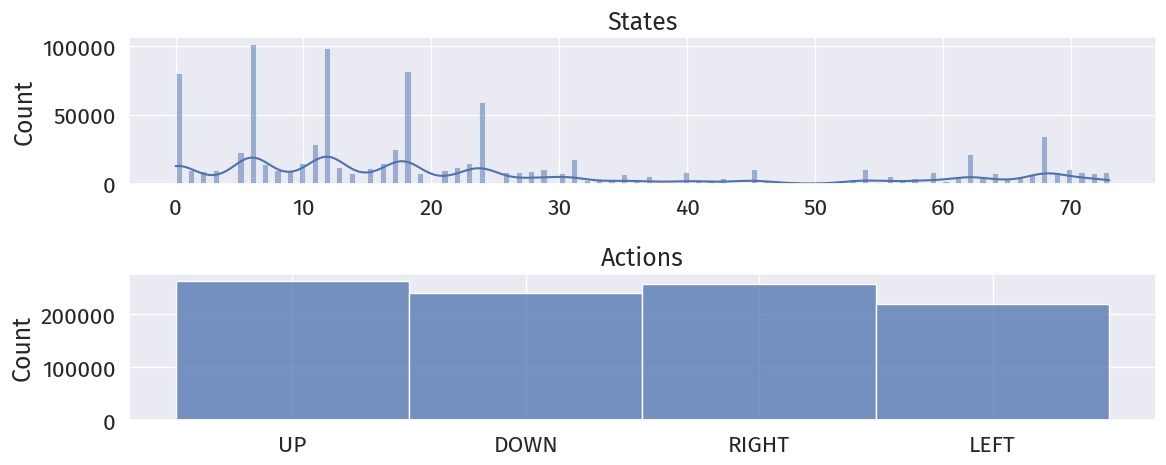

In [16]:
plotting.plot_states_actions_distribution(all_states, all_actions)

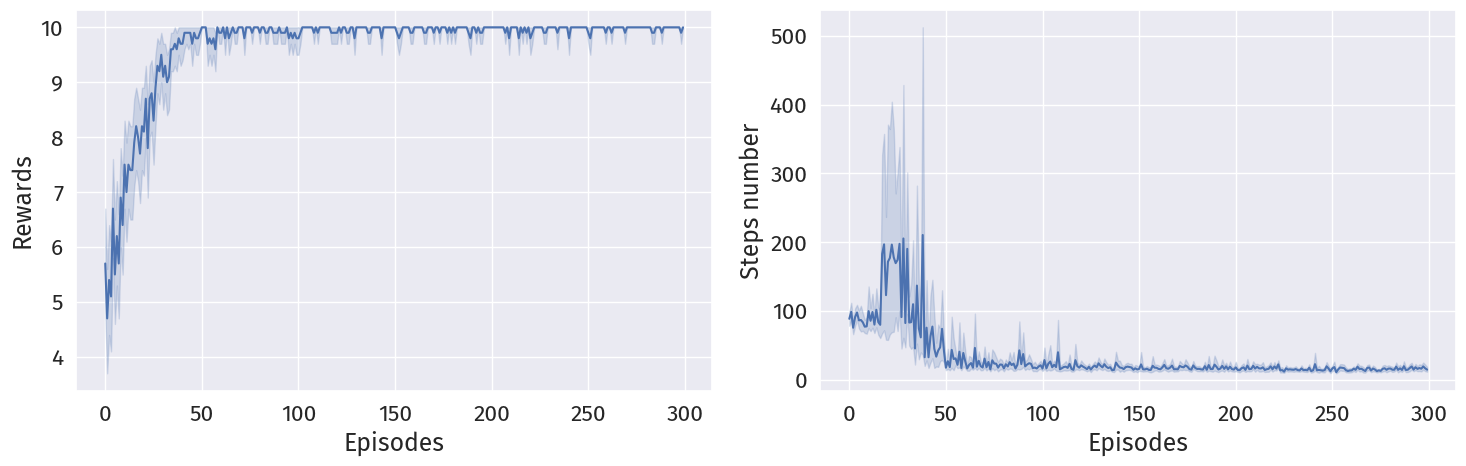

In [17]:
plotting.plot_steps_and_rewards(res)

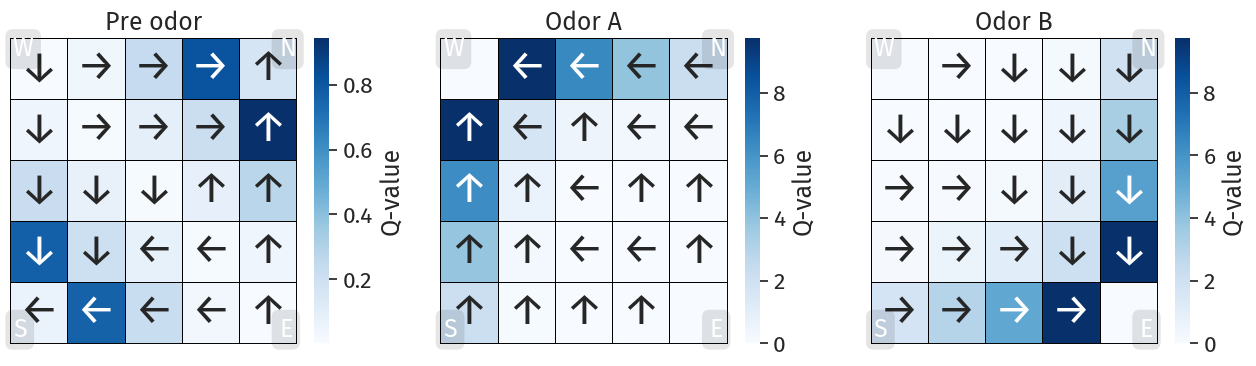

In [18]:
plotting.plot_q_values_maps(qtable, env.rows, env.cols, CONTEXTS_LABELS)

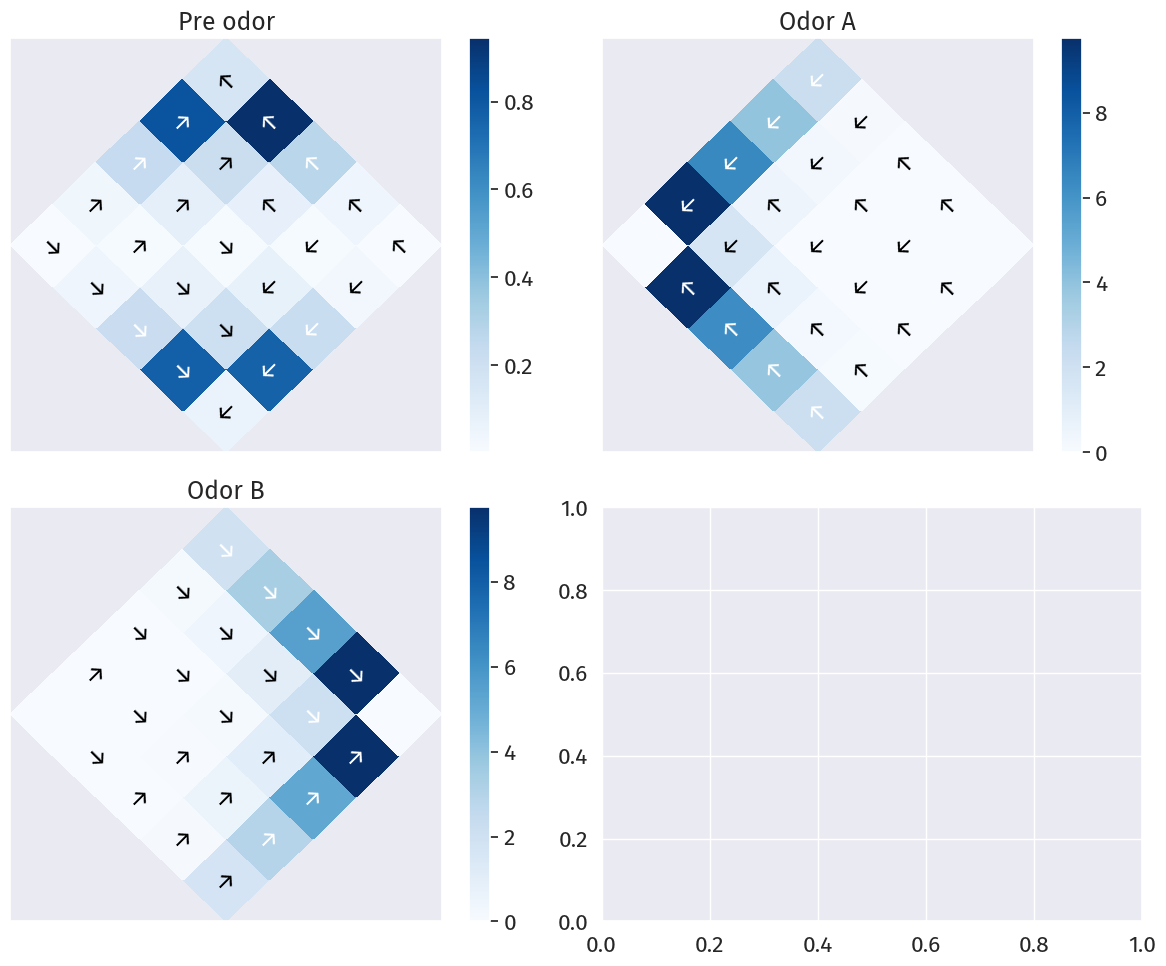

In [19]:
plotting.plot_rotated_q_values_maps(qtable, env.rows, env.cols, CONTEXTS_LABELS)

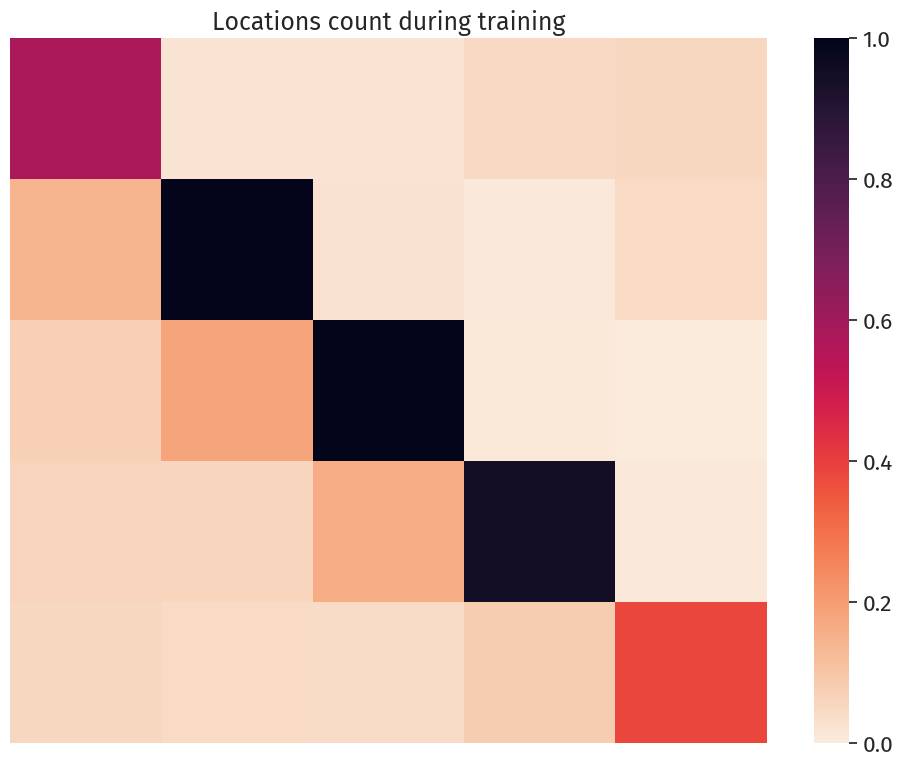

In [20]:
plotting.plot_location_count(
    all_state_composite,
    tiles_locations=env.tiles_locations,
    cols=env.cols,
    rows=env.rows,
    cues=None,
    contexts_labels=None,
)

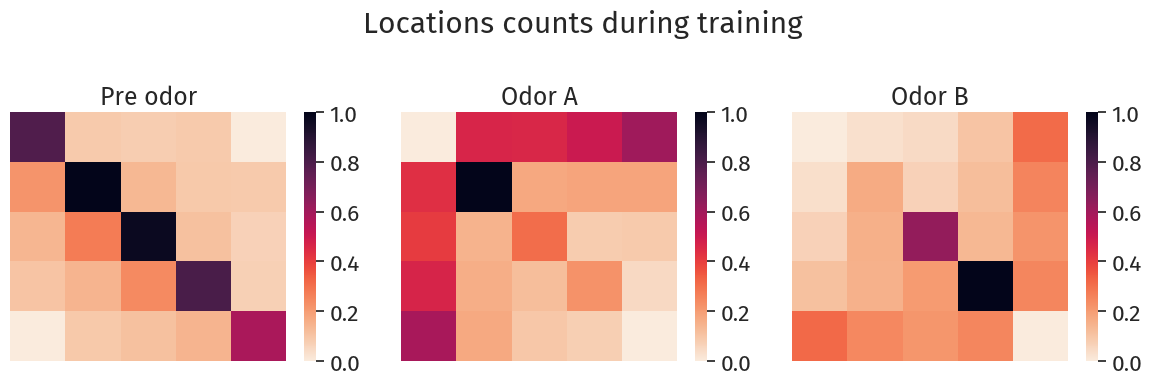

In [21]:
plotting.plot_location_count(
    all_state_composite,
    tiles_locations=env.tiles_locations,
    cols=env.cols,
    rows=env.rows,
    cues=Cues,
    contexts_labels=CONTEXTS_LABELS,
)